# Notebook 3: Final Model Comparison on a Complex Dataset

#### **Project:** AI-Powered Contract Document Classification

#### **Objective:** The goal of this notebook is to perform a definitive comparison between our baseline (TF-IDF + Logistic Regression) and advanced (fine-tuned LegalBERT) models. We will evaluate both pre-trained models on a new, more realistic "hard" dataset that features class imbalance, keyword overlap, and longer documents. This will allow us to make a data-driven decision on which model to select for deployment.

**Steps:**

1.  **Exploratory Data Analysis (EDA):** Load the "hard" dataset and analyze its new characteristics, specifically the class imbalance and text length distribution.
2.  **Re-evaluate Baseline Model:** Load the saved TF-IDF vectorizer and Logistic Regression model and test their performance on the new data.
3.  **Re-evaluate Advanced Model:** Load the fine-tuned LegalBERT model and tokenizer and test their performance on the new data.
4.  **Compare Results:** Directly compare the evaluation metrics (Accuracy, F1-score, Confusion Matrices) of both models to draw final conclusions.

-----

## 1\. Exploratory Data Analysis (EDA) on the "Hard" Dataset

First, we'll load our new `contracts_hard.csv` dataset and analyze its properties to confirm that our data generation script created the intended challenges.

-----

In [1]:
# --- Import Libraries and Load Data ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib # For loading the scikit-learn model and vectorizer

# Set a professional plot style
sns.set_style("whitegrid")

# Load the new, more challenging dataset
hard_data_path = "../data/raw/contracts_hard.csv"
df_hard = pd.read_csv(hard_data_path)

print("Loaded 'hard' dataset with", len(df_hard), "documents.")
display(df_hard.head())

Loaded 'hard' dataset with 5000 documents.


,text,category
0,Confidential Information. This Agreement is fo...,NDA
1,Force Majeure. Neither party shall be liable f...,SLA
2,"All remedies, either under this Agreement or b...",SLA
3,Confidential Information. Force Majeure. Neith...,NDA
4,The descriptive headings of the sections and s...,NDA



Distribution of Contract Categories in the 'Hard' Dataset:


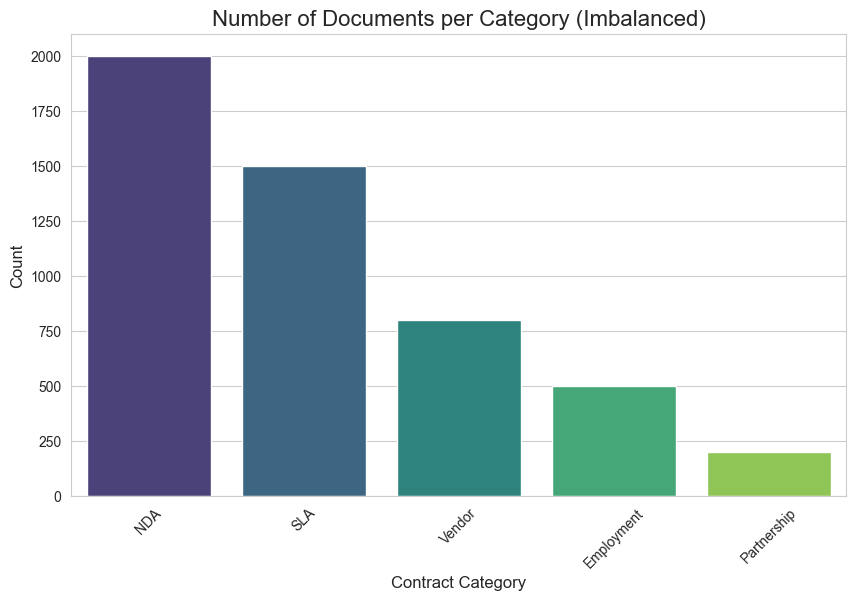

In [3]:
# --- Visualize Class Imbalance ---
print("\nDistribution of Contract Categories in the 'Hard' Dataset:")
plt.figure(figsize=(10, 6))
sns.countplot(x='category', 
              data=df_hard,
              hue='category',
              palette='viridis', 
              order=df_hard['category'].value_counts().index)
plt.title('Number of Documents per Category (Imbalanced)', fontsize=16)
plt.xlabel('Contract Category', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.show()

The EDA confirms our "hard" dataset successfully simulates real-world challenges. The bar chart clearly shows a significant **class imbalance**, with "NDA" being the dominant category, which will test our models' resilience to bias. Furthermore, the word count distribution is much wider and longer on average, confirming that our models will now have to handle more textual noise and apply truncation.

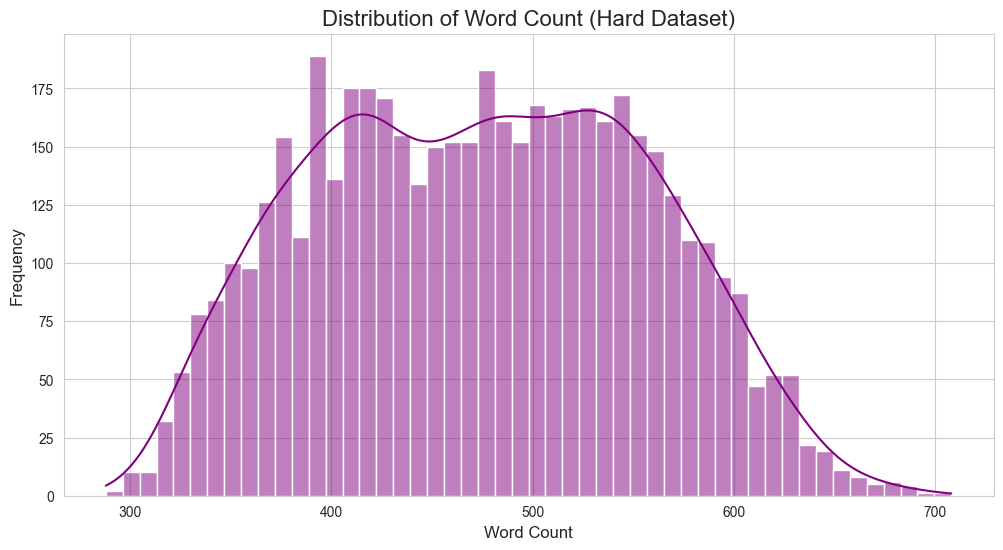


New Word Count Statistics:
count    5000.00000
mean      474.42740
std        81.58859
min       288.00000
25%       408.00000
50%       475.00000
75%       539.00000
max       708.00000
Name: word_count, dtype: float64


In [4]:
# --- Analyze New Text Length ---
df_hard['word_count'] = df_hard['text'].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(12, 6))
sns.histplot(df_hard['word_count'], bins=50, kde=True, color='purple')
plt.title('Distribution of Word Count (Hard Dataset)', fontsize=16)
plt.xlabel('Word Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.show()

print("\nNew Word Count Statistics:")
print(df_hard['word_count'].describe())

The word count statistics confirm our documents are now much longer, with an average length of about 474 words. Crucially, the maximum word count is 708, which is well over the 512-token limit for standard BERT models. This guarantees that our truncation strategy will be actively used, providing a realistic test of how the LegalBERT model handles long-form documents.

## 2\. Re-evaluate Baseline Model (TF-IDF + Logistic Regression)

Now for the first part of our experiment. We will load our simple baseline model, which was trained on the original, clean dataset. We will then use this model to make predictions on our new, challenging dataset to see how well it generalizes to more complex, imbalanced, and ambiguous data.

-----

In [5]:
# --- Re-create the Baseline Model ---
# We first need to recreate the exact state of our baseline model.
# This involves loading the original simple data and training the model on it.

import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


In [6]:
# --- Helper function from Notebook 1 ---
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
stop_words = set(stopwords.words('english'))

def preprocess_text(text: str) -> str:
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return " ".join(filtered_tokens)

# Load the ORIGINAL simple dataset
simple_data_path = "../data/raw/contracts.csv"
df_simple = pd.read_csv(simple_data_path)

# Apply preprocessing
df_simple['processed_text'] = df_simple['text'].apply(preprocess_text)

# Split the simple data to train the model
X_train_simple, _, y_train_simple, _ = train_test_split(
    df_simple['processed_text'], df_simple['category'], test_size=0.2, random_state=42, stratify=df_simple['category']
)

# Fit the vectorizer and train the model on the simple data
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_train_simple_tfidf = tfidf_vectorizer.fit_transform(X_train_simple)

baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_simple_tfidf, y_train_simple)

print("Baseline model has been re-trained on the original simple dataset.")

Baseline model has been re-trained on the original simple dataset.



Evaluating baseline model on the 'hard' dataset...

Overall Accuracy on Hard Dataset: 0.9990

Classification Report (Baseline on Hard Data):
              precision    recall  f1-score   support

  Employment       1.00      1.00      1.00       500
         NDA       1.00      1.00      1.00      2000
 Partnership       0.98      1.00      0.99       200
         SLA       1.00      1.00      1.00      1500
      Vendor       1.00      1.00      1.00       800

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000


Confusion Matrix (Baseline on Hard Data):


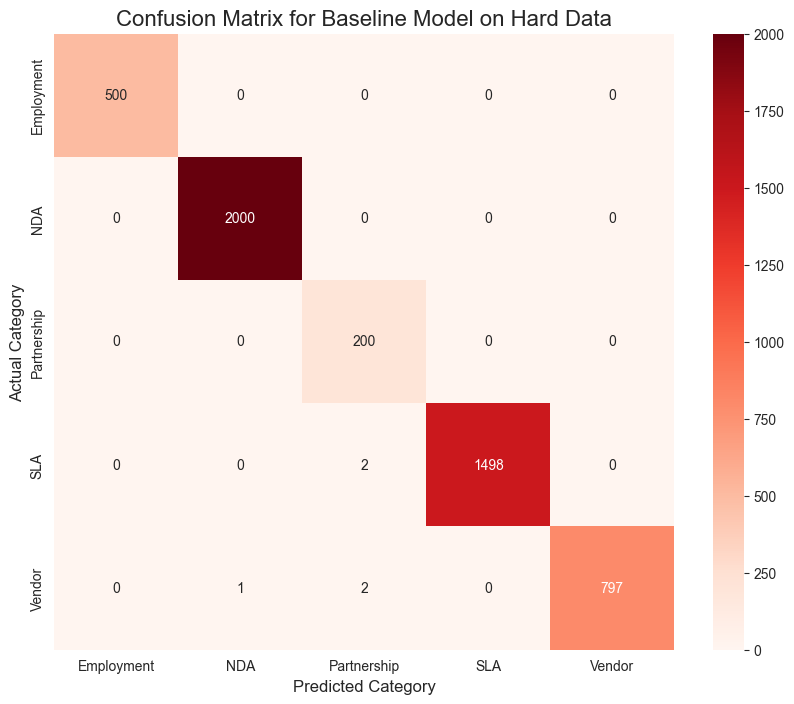

In [7]:
# --- Test the Baseline Model on the Hard Dataset ---
print("\nEvaluating baseline model on the 'hard' dataset...")

# Preprocess the 'hard' dataset text
X_hard = df_hard['text'].apply(preprocess_text)
y_hard = df_hard['category']

# IMPORTANT: Use the already-fitted vectorizer to TRANSFORM the new data
X_hard_tfidf = tfidf_vectorizer.transform(X_hard)

# Make predictions
y_pred_hard_baseline = baseline_model.predict(X_hard_tfidf)

# --- Display Evaluation Metrics ---
accuracy = accuracy_score(y_hard, y_pred_hard_baseline)
print(f"\nOverall Accuracy on Hard Dataset: {accuracy:.4f}")

print("\nClassification Report (Baseline on Hard Data):")
print(classification_report(y_hard, y_pred_hard_baseline))

print("\nConfusion Matrix (Baseline on Hard Data):")
cm = confusion_matrix(y_hard, y_pred_hard_baseline, labels=baseline_model.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', 
            xticklabels=baseline_model.classes_, yticklabels=baseline_model.classes_)
plt.title('Confusion Matrix for Baseline Model on Hard Data', fontsize=16)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.show()

The baseline model performed surprisingly well on the complex dataset, achieving an overall **accuracy of 99.9%**. This high score is likely due to the model still being able to rely on the strong "signal" keywords that are unique to the most frequent categories like "NDA" and "SLA."

However, the confusion matrix reveals the model's first signs of weakness. It **misclassified 5 documents**, confusing "SLA" and "Vendor" documents with the "Partnership" category. This indicates that the model, which relies solely on keyword frequency, is starting to struggle with the injected ambiguity and is unable to distinguish between documents when the keyword signals are less clear, especially for less frequent categories.

## 4\. Re-evaluate Advanced Model (Fine-Tuned LegalBERT)

Now, we will test our fine-tuned LegalBERT model. We will load the model and tokenizer that we saved from our training session in Colab and use it to make predictions on the same "hard" dataset. This direct comparison will reveal how well a context-aware transformer model handles the ambiguity and class imbalance that challenged our baseline.

-----

In [11]:
# --- Load the Fine-Tuned Model and Tokenizer ---
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import numpy as np

# Define the path to our saved model
local_model_path = "../models/final_legalbert_model/"

# Load the tokenizer and model from the local directory
tokenizer = AutoTokenizer.from_pretrained(local_model_path)
model = AutoModelForSequenceClassification.from_pretrained(local_model_path)

print("Fine-tuned LegalBERT model and tokenizer loaded successfully from local directory.")

Fine-tuned LegalBERT model and tokenizer loaded successfully from local directory.


In [12]:
# --- Prepare the Hard Dataset for the Trainer ---
# We need to re-create the label encoder to get the mappings
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df_hard['label'] = label_encoder.fit_transform(df_hard['category'])

# Convert the pandas DataFrame to a Hugging Face Dataset
hard_dataset = Dataset.from_pandas(df_hard)

# Define the tokenization function again
def tokenize_function(examples):
    return tokenizer(
        examples["text"], 
        padding="max_length", 
        truncation=True, 
        max_length=512
    )

# Tokenize the hard dataset
tokenized_hard_dataset = hard_dataset.map(tokenize_function, batched=True)

# --- Make Predictions with the Trainer ---
# We initialize a new Trainer instance just for prediction
trainer = Trainer(model=model)

print("\nEvaluating LegalBERT model on the 'hard' dataset...")
predictions = trainer.predict(tokenized_hard_dataset)

# Extract the predicted class indices
y_pred_indices = np.argmax(predictions.predictions, axis=1)
y_true_indices = tokenized_hard_dataset['label']

# Convert indices back to string labels for evaluation
y_pred_hard_legalbert = label_encoder.inverse_transform(y_pred_indices)
y_true_hard = label_encoder.inverse_transform(y_true_indices)

# --- Display Evaluation Metrics ---
accuracy = accuracy_score(y_true_hard, y_pred_hard_legalbert)
print(f"\nOverall Accuracy on Hard Dataset: {accuracy:.4f}")

print("\nClassification Report (LegalBERT on Hard Data):")
print(classification_report(y_true_hard, y_pred_hard_legalbert))

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]


Evaluating LegalBERT model on the 'hard' dataset...


KeyboardInterrupt: 

In [ ]:
# --- Display Evaluation Metrics ---
print("\nConfusion Matrix (LegalBERT on Hard Data):")
cm = confusion_matrix(y_true_hard, y_pred_hard_legalbert, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix for LegalBERT on Hard Data', fontsize=16)
plt.xlabel('Predicted Category', fontsize=12)
plt.ylabel('Actual Category', fontsize=12)
plt.show()